# Step 1: Install Dependencies

In [1]:
!pip install -q python-binance
!pip install -q plotly
!pip install -q pendulum

     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 288 kB 12.6 MB/s 
     |████████████████████████████████| 103 kB 72.9 MB/s 
     |████████████████████████████████| 1.1 MB 65.2 MB/s 
     |████████████████████████████████| 160 kB 70.3 MB/s 
     |████████████████████████████████| 271 kB 91.4 MB/s 
     |████████████████████████████████| 192 kB 68.6 MB/s 
     |████████████████████████████████| 155 kB 4.3 MB/s 
     |████████████████████████████████| 489 kB 45.8 MB/s 


In [112]:
import os
import pendulum
import pandas as pd
import numpy as np
from binance import Client
import matplotlib.pyplot as plt

from plotly.subplots import make_subplots
import plotly.graph_objects as go

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Step 2: Create Dataset



## Collect data from Binance API

In [3]:
binance_client = Client(testnet=False)
dt_start = pendulum.datetime(2012, 1, 1, tz='Asia/Bangkok').to_atom_string()
dt_end = pendulum.datetime(2022, 1, 1, tz='Asia/Bangkok').to_atom_string()
klines = binance_client.get_historical_klines(symbol='BTCUSDT', interval='30m', start_str=dt_start, end_str=dt_end)

In [4]:
print('datapoint amount: ', len(klines))
print(klines[0])

datapoint amount:  76410
[1502942400000, '4261.48000000', '4280.56000000', '4261.32000000', '4261.45000000', '11.30892600', 1502944199999, '48224.75400837', 49, '3.93617400', '16793.03995768', '7922.57993329']


# Step 3: Preprocess Data

In [ ]:
"""
`klines` data format
[
    [
        1499040000000,      # Open time
        "0.01634790",       # Open
        "0.80000000",       # High
        "0.01575800",       # Low
        "0.01577100",       # Close
        "148976.11427815",  # Volume
        1499644799999,      # Close time
        "2434.19055334",    # Quote asset volume
        308,                # Number of trades
        "1756.87402397",    # Taker buy base asset volume
        "28.46694368",      # Taker buy quote asset volume
        "17928899.62484339" # Can be ignored
    ],
    ...
]
"""

## Create DataFrame and select only some columns

In [5]:
def reformat_klines(klines_info: list):
    """create pd.DataFrame and change data type of columns"""
    include_columns = [0, 1, 2, 3, 4, 5, 6, 8]

    df = pd.DataFrame(klines_info)
    df = df[include_columns]

    for col in [0, 6]:
        df[col] = df[col].astype('str').str.slice(stop=10).astype('int')
    for col in [1, 2, 3, 4, 5]:
        df[col] = df[col].astype('float')

    df.columns = ['open_time', 'open_price', 'high_price', 'low_price', 'close_price', 'volume', 'close_time', 'number_of_trade']
    
    df['datetime'] = df['open_time'].map(lambda x: pendulum.from_timestamp(x, tz='Asia/Bangkok'))
    df.set_index('datetime', inplace=True)
    df.index = df.index.tz_convert('Asia/Bangkok')
    
    return df

df = reformat_klines(klines)

In [6]:
df

open_time  open_price  ...  close_time  number_of_trade
datetime                                           ...                             
2017-08-17 11:00:00+07:00  1502942400     4261.48  ...  1502944199               49
2017-08-17 11:30:00+07:00  1502944200     4280.00  ...  1502945999              122
2017-08-17 12:00:00+07:00  1502946000     4308.83  ...  1502947799               73
2017-08-17 12:30:00+07:00  1502947800     4320.00  ...  1502949599               29
2017-08-17 13:00:00+07:00  1502949600     4330.29  ...  1502951399               14
...                               ...         ...  ...         ...              ...
2021-12-31 22:00:00+07:00  1640962800    47976.51  ...  1640964599            19548
2021-12-31 22:30:00+07:00  1640964600    47999.54  ...  1640966399            18239
2021-12-31 23:00:00+07:00  1640966400    48005.37  ...  1640968199            15292
2021-12-31 23:30:00+07:00  1640968200    48104.00  ...  1640969999            32434
2022-01-01 00:00:00+07:00  1640970000    47471.67  ...  1640971799            34558

[76410 rows x 8 columns]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 76410 entries, 2017-08-17 11:00:00+07:00 to 2022-01-01 00:00:00+07:00
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   open_time        76410 non-null  int64  
 1   open_price       76410 non-null  float64
 2   high_price       76410 non-null  float64
 3   low_price        76410 non-null  float64
 4   close_price      76410 non-null  float64
 5   volume           76410 non-null  float64
 6   close_time       76410 non-null  int64  
 7   number_of_trade  76410 non-null  int64  
dtypes: float64(5), int64(3)
memory usage: 5.2 MB


## Validate and Cleaning the dataset
Steps
- Convert date-times to Pandas datetime format.
- Check for Null values and decide what to do with them.
- Check for missing time steps and insert Null values if there are missing time steps.
- If Nulls are inserted for missing time steps, decide what to do with them.

### Check for null values

In [8]:
df.isna().sum()

open_time          0
open_price         0
high_price         0
low_price          0
close_price        0
volume             0
close_time         0
number_of_trade    0
dtype: int64

### Check for missing datetime (30-min interval)

In [9]:
start_datetime = df.index.min()
end_datetime = df.index.max()
missing_datetimes = pd.date_range(start=start_datetime, end=end_datetime, freq='30min', tz='Asia/Bangkok').difference(df.index)
missing_datetimes

DatetimeIndex(['2017-09-06 23:00:00+07:00', '2017-09-06 23:30:00+07:00',
               '2017-09-07 00:00:00+07:00', '2017-09-07 00:30:00+07:00',
               '2017-09-07 01:00:00+07:00', '2017-09-07 01:30:00+07:00',
               '2017-09-07 02:00:00+07:00', '2017-09-07 02:30:00+07:00',
               '2017-09-07 03:00:00+07:00', '2017-09-07 03:30:00+07:00',
               ...
               '2021-08-13 10:30:00+07:00', '2021-08-13 11:00:00+07:00',
               '2021-08-13 11:30:00+07:00', '2021-08-13 12:00:00+07:00',
               '2021-08-13 12:30:00+07:00', '2021-08-13 13:00:00+07:00',
               '2021-09-29 14:00:00+07:00', '2021-09-29 14:30:00+07:00',
               '2021-09-29 15:00:00+07:00', '2021-09-29 15:30:00+07:00'],
              dtype='datetime64[ns, Asia/Bangkok]', length=358, freq=None)

### Insert null values in all missing timesteps

In [10]:
df_new = df.copy()
df_new = df_new.reindex(pd.date_range(df_new.index.min(), df_new.index.max(), freq='30min', tz='Asia/Bangkok'))
df_new

open_time  ...  number_of_trade
2017-08-17 11:00:00+07:00  1.502942e+09  ...             49.0
2017-08-17 11:30:00+07:00  1.502944e+09  ...            122.0
2017-08-17 12:00:00+07:00  1.502946e+09  ...             73.0
2017-08-17 12:30:00+07:00  1.502948e+09  ...             29.0
2017-08-17 13:00:00+07:00  1.502950e+09  ...             14.0
...                                 ...  ...              ...
2021-12-31 22:00:00+07:00  1.640963e+09  ...          19548.0
2021-12-31 22:30:00+07:00  1.640965e+09  ...          18239.0
2021-12-31 23:00:00+07:00  1.640966e+09  ...          15292.0
2021-12-31 23:30:00+07:00  1.640968e+09  ...          32434.0
2022-01-01 00:00:00+07:00  1.640970e+09  ...          34558.0

[76683 rows x 8 columns]

In [11]:
df_new.loc['2017-09-06T23:00:00+07:00']

open_time         NaN
open_price        NaN
high_price        NaN
low_price         NaN
close_price       NaN
volume            NaN
close_time        NaN
number_of_trade   NaN
Name: 2017-09-06 23:00:00+07:00, dtype: float64

In [12]:
df_new.isna().sum()

open_time          358
open_price         358
high_price         358
low_price          358
close_price        358
volume             358
close_time         358
number_of_trade    358
dtype: int64

### Filling data in each null values

In [193]:
df_final = df_new.copy()

df_final['datetime'] = df_final.index

for missing_datetime in missing_datetimes:
    timestamp = df_final.loc[missing_datetime, 'datetime'].value
    timestamp = int(str(timestamp)[:10])
    previous_dt_string = pendulum.parse(str(missing_datetime)).subtract(minutes=30).to_atom_string()

    # filling missing values for `open_time`
    df_final.loc[missing_datetime, 'open_time'] = timestamp

    # filling missing values for `close_time`
    df_final.loc[missing_datetime, 'close_time'] = pendulum.from_timestamp(timestamp).add(minutes=30).subtract(seconds=1).timestamp()

    # filling missing values for other columns using average values
    df_final.loc[missing_datetime, 'open_price'] = df_final.loc[previous_dt_string, 'open_price']
    df_final.loc[missing_datetime, 'high_price'] = df_final.loc[previous_dt_string, 'high_price']
    df_final.loc[missing_datetime, 'low_price'] = df_final.loc[previous_dt_string, 'low_price']
    df_final.loc[missing_datetime, 'close_price'] = df_final.loc[previous_dt_string, 'close_price']
    df_final.loc[missing_datetime, 'volume'] = df_final.loc[previous_dt_string, 'volume']
    df_final.loc[missing_datetime, 'number_of_trade'] = df_final.loc[previous_dt_string, 'number_of_trade']

In [194]:
df_final.isna().sum()

open_time          0
open_price         0
high_price         0
low_price          0
close_price        0
volume             0
close_time         0
number_of_trade    0
datetime           0
dtype: int64

In [196]:
df_final.to_csv('btcusdt_2017_2021.csv', index=False)

# Step 4: Data Visualization

In [197]:
symbol = 'BTCUSDT'
interval_label = '30min'
lowest_price = df_final[df_final['low_price'] != 0]['low_price'].min()
highest_price = df_final['high_price'].max()

subfig = go.Candlestick(x=df_final.index,
                        open=df_final['open_price'],
                        high=df_final['high_price'],
                        low=df_final['low_price'],
                        close=df_final['close_price'],
                        showlegend=False)

fig_layout = go.Layout({"title": f'<b>{symbol} Price</b> ({interval_label})<br>high: {highest_price}, low: {lowest_price}',
                        "yaxis": {"title": "<b>USDT</b>"},
                        "xaxis": {"title": "<b>DateTime</b>"},
                        "showlegend": False,
                        "xaxis_rangeslider_visible": False,
                        "height": 500,
                        "width": 800})

fig = go.Figure(data=[subfig], layout=fig_layout)

fig.show()

# Step 5: Model Declaration

In [198]:
class LSTMForecast(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob, device):
        super(LSTMForecast, self).__init__()

        self.name = 'LSTMForecast'

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.dropout_prob = dropout_prob
        self.device = device

        self.lstm = nn.LSTM(
            input_size=self.input_size, 
            hidden_size=self.hidden_size, 
            num_layers=self.num_layers, 
            batch_first=True, 
            dropout=self.dropout_prob
        )

        self.fc = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x, future=0):
        # TODO: implement future forecast when parameter `future` > 0
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_().to(self.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_().to(self.device)

        output, (hn, cn) = self.lstm(x, (h_0, c_0))

        output = output[:, -1, :]
        output = self.fc(output)

        return output

# Step 6: Training Preparation

## Create DataFrame from CSV file

In [199]:
csv_path = 'btcusdt_2017_2021.csv'
df = pd.read_csv(csv_path)
df['datetime'] = df['datetime'].map(lambda x: pendulum.parse(x, tz='Asia/Bangkok'))
df.set_index('datetime', inplace=True)
df.index = df.index.tz_convert('Asia/Bangkok')
print('column names: ', df.columns)
df.head()

column names:  Index(['open_time', 'open_price', 'high_price', 'low_price', 'close_price',
       'volume', 'close_time', 'number_of_trade'],
      dtype='object')


open_time  ...  number_of_trade
datetime                                 ...                 
2017-08-17 11:00:00+07:00  1.502942e+09  ...             49.0
2017-08-17 11:30:00+07:00  1.502944e+09  ...            122.0
2017-08-17 12:00:00+07:00  1.502946e+09  ...             73.0
2017-08-17 12:30:00+07:00  1.502948e+09  ...             29.0
2017-08-17 13:00:00+07:00  1.502950e+09  ...             14.0

[5 rows x 8 columns]

## Train-Val-Test split on the dataset

In [259]:
def feature_label_split(df, target_col, drop_cols: list):
    y = df[[target_col]]
    X = df.drop(columns=drop_cols)
    return X, y

def train_val_test_split(df, target_col, drop_cols, test_ratio):
    # val_ratio = test_ratio / (1 - test_ratio)
    X, y = feature_label_split(df, target_col, drop_cols)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
    # X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)
    # return X_train, X_val, X_test, y_train, y_val, y_test
    return X_train, X_val, y_train, y_val

drop_cols = ['open_time', 'close_time', 'close_price']
X_train, X_val, y_train, y_val = train_val_test_split(df, 'close_price', drop_cols, 0.2)

In [260]:
X_train

open_price  high_price  ...       volume  number_of_trade
datetime                                           ...                              
2017-08-17 11:00:00+07:00     4261.48     4280.56  ...    11.308926             49.0
2017-08-17 11:30:00+07:00     4280.00     4313.62  ...    35.872083            122.0
2017-08-17 12:00:00+07:00     4308.83     4328.69  ...    21.048648             73.0
2017-08-17 12:30:00+07:00     4320.00     4320.00  ...     2.186268             29.0
2017-08-17 13:00:00+07:00     4330.29     4330.29  ...     3.566277             14.0
...                               ...         ...  ...          ...              ...
2021-02-15 09:30:00+07:00    46365.20    47200.00  ...  4729.852702         124863.0
2021-02-15 10:00:00+07:00    46874.01    47269.09  ...  2480.304209          77271.0
2021-02-15 10:30:00+07:00    47230.01    47250.07  ...  1708.147794          53159.0
2021-02-15 11:00:00+07:00    47120.31    47136.02  ...  2346.323828          55933.0
2021-02-15 11:30:00+07:00    46649.79    46959.44  ...  2617.410696          61332.0

[61346 rows x 5 columns]

In [261]:
X_val

open_price  high_price  ...       volume  number_of_trade
datetime                                           ...                              
2020-04-01 23:30:00+07:00     6196.40     6214.53  ...  2640.763792          21509.0
2020-04-02 00:00:00+07:00     6182.38     6208.00  ...  1475.245102          13314.0
2020-04-02 00:30:00+07:00     6196.48     6212.00  ...   939.614240           9551.0
2020-04-02 01:00:00+07:00     6194.56     6220.00  ...   942.238476          10605.0
2020-04-02 01:30:00+07:00     6214.35     6215.01  ...   858.852213           9610.0
...                               ...         ...  ...          ...              ...
2021-02-15 09:30:00+07:00    46365.20    47200.00  ...  4729.852702         124863.0
2021-02-15 10:00:00+07:00    46874.01    47269.09  ...  2480.304209          77271.0
2021-02-15 10:30:00+07:00    47230.01    47250.07  ...  1708.147794          53159.0
2021-02-15 11:00:00+07:00    47120.31    47136.02  ...  2346.323828          55933.0
2021-02-15 11:30:00+07:00    46649.79    46959.44  ...  2617.410696          61332.0

[15337 rows x 5 columns]

In [262]:
# X_test

## Scale the dataset with `MinMaxScaler`

In [204]:
def get_scaler(scaler):
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()

In [263]:
scaler = get_scaler('minmax')

X_train_arr = scaler.fit_transform(X_train)
X_val_arr = scaler.transform(X_val)
# X_test_arr = scaler.transform(X_test)

y_train_arr = scaler.fit_transform(y_train)
y_val_arr = scaler.transform(y_val)
# y_test_arr = scaler.transform(y_test)

## Create DataLoader

In [264]:
batch_size = 64

train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)

val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)

# test_features = torch.Tensor(X_test_arr)
# test_targets = torch.Tensor(y_test_arr)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
# test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
# test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)

# mini-batch testing to evaluate the program or model
val_loader_one = DataLoader(val, batch_size=1, shuffle=False, drop_last=True)

# Step 7: Model Training

In [265]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
        self.device = Optimization.set_device()

        self.model.to(self.device)

    @staticmethod
    def create_dir(dir_name):
        try:
            os.mkdir(dir_name)
        except Exception as e:
            pass
            # print(f'{dir_name} already been created')

    @staticmethod
    def set_device(display=False):
        """transfer data to `gpu` for faster processing time"""
        if torch.cuda.is_available():
            device = "cuda:0"
        else:
            device = "cpu"
        if display:
            print("device : ", device)
        return torch.device(device)

    def model_to_cpu(self):
        self.model.cpu()
    
    def model_to_gpu(self):
        self.model.to(self.device)

    def train_step(self, x, y):
        self.model.train()  # Sets model to train mode
        pred = self.model(x)  # Makes predictions
        loss = self.loss_fn(y, pred)  # Computes loss
        loss.backward()  # Computes gradients

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        return loss.item()

    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
        _dt_string = pendulum.now(tz='Asia/Bangkok').to_datetime_string()
        Optimization.create_dir('models')
        model_path = f'models/{self.model.name}_{_dt_string.replace(" " , "T")}.pt'

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(self.device)
                y_batch = y_batch.to(self.device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(self.device)
                    y_val = y_val.to(self.device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) or (epoch % 50 == 0):
                print(f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}")

        torch.save(self.model.state_dict(), model_path)
        print(f'Saved model to {model_path}')

    def evaluate(self, test_loader, batch_size=1, n_features=1):
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(self.device)
                y_test = y_test.to(self.device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.to('cpu').detach().numpy())
                values.append(y_test.to('cpu').detach().numpy())

        return predictions, values

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

In [266]:
def set_device(display=False):
    """transfer data to `gpu` for faster processing time"""
    if torch.cuda.is_available():
        device = "cuda:0"
    else:
        device = "cpu"
    if display:
        print("device : ", device)
    return torch.device(device)

In [267]:
input_size = len(X_train.columns)
output_size = 1
hidden_size = 64
num_layers = 3
batch_size = 64
dropout_prob = 0.2
n_epochs = 200
learning_rate = 1e-3
weight_decay = 1e-6
device_type = 'gpu'

if device_type == 'gpu':
    device = set_device(display=True)
else:
    device = torch.device('cpu')

model = LSTMForecast(input_size, hidden_size, num_layers, output_size, dropout_prob, device)
model.to(device)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

device :  cuda:0


In [268]:
opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_size)

[1/200] Training loss: 0.0010	 Validation loss: 0.4092
[2/200] Training loss: 0.0071	 Validation loss: 0.1989
[3/200] Training loss: 0.0052	 Validation loss: 0.0627
[4/200] Training loss: 0.0011	 Validation loss: 0.0024
[5/200] Training loss: 0.0006	 Validation loss: 0.0029
[6/200] Training loss: 0.0005	 Validation loss: 0.0046
[7/200] Training loss: 0.0005	 Validation loss: 0.0081
[8/200] Training loss: 0.0005	 Validation loss: 0.0129
[9/200] Training loss: 0.0005	 Validation loss: 0.0095
[10/200] Training loss: 0.0005	 Validation loss: 0.0068
[50/200] Training loss: 0.0006	 Validation loss: 0.0033
[100/200] Training loss: 0.0004	 Validation loss: 0.0024
[150/200] Training loss: 0.0003	 Validation loss: 0.0019
[200/200] Training loss: 0.0004	 Validation loss: 0.0011
Saved model to models/LSTMForecast_2022-01-03T13:25:45.pt


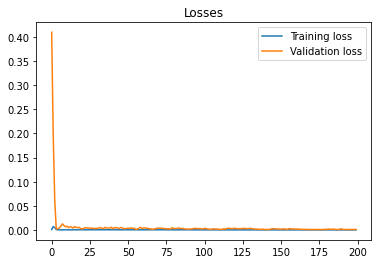

In [269]:
opt.plot_losses()

# Step 8: Model Evaluation

In [270]:
predictions, values = opt.evaluate(val_loader_one, batch_size=1, n_features=input_size)

In [271]:
def inverse_transform(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df


def format_predictions(predictions, values, df_test, scaler):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_result = pd.DataFrame(data={"value": vals, "prediction": preds}, index=df_test.iloc[:len(vals)].index)
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, [["value", "prediction"]])
    return df_result


df_result = format_predictions(predictions, values, X_val, scaler)

In [272]:
def calculate_metrics(df):
    return {'mae' : mean_absolute_error(df.value, df.prediction),
            'rmse' : mean_squared_error(df.value, df.prediction) ** 0.5,
            'r2' : r2_score(df.value, df.prediction)}

result_metrics = calculate_metrics(df_result)
result_metrics

{'mae': 1224.7137, 'r2': 0.9754498089378567, 'rmse': 1527.0762096241301}

In [273]:
df_result

value    prediction
datetime                                             
2020-04-01 23:30:00+07:00   6182.380371   8423.652344
2020-04-02 00:00:00+07:00   6196.649902   8421.112305
2020-04-02 00:30:00+07:00   6194.569824   8425.938477
2020-04-02 01:00:00+07:00   6214.500000   8428.041992
2020-04-02 01:30:00+07:00   6186.860352   8430.063477
...                                 ...           ...
2021-02-15 09:30:00+07:00  46874.019531  47600.398438
2021-02-15 10:00:00+07:00  47230.007812  47692.632812
2021-02-15 10:30:00+07:00  47120.300781  47739.941406
2021-02-15 11:00:00+07:00  46649.792969  47649.187500
2021-02-15 11:30:00+07:00  46866.570312  47508.835938

[15337 rows x 2 columns]

In [274]:
def plot_predictions(df_result):
    titles = ['']
    fig = make_subplots(rows=1, cols=1, subplot_titles=titles)

    fig.append_trace(go.Scatter(
        x=df_result.index,
        y=df_result['value'],
        name="values",
        line=dict(width=3, color='black')
    ), row=1, col=1)
    fig.update_yaxes(title_text="<b>Number of people</b>", row=1, col=1)

    fig.append_trace(go.Scatter(
        x=df_result.index,
        y=df_result['prediction'],
        name="predictions",
        line=dict(width=3, color='red')
    ), row=1, col=1)

    fig.update_layout(height=600, width=800)
    fig.update_layout(title=f'<b>BTCUSDT Price Prediction</b>')

    return fig

fig = plot_predictions(df_result)
fig.show()

# Next Steps

- integrate `sliding window`
- future forecast